IFC TO GRAPH

Vertices:
Node ID: 2321, Data: {'id': 2321, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVlI', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3049=IfcLocalPlacement(#3039,#3048)', 'Representation': '#2317=IfcProductDefinitionShape($,$,(#2316))', 'Tag': '1664109', 'OverallHeight': 2100.0, 'OverallWidth': 850.0}
Node ID: 2286, Data: {'id': 2286, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVkU', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3029=IfcLocalPlacement(#3019,#3028)', 'Representation': '#2282=IfcProductDefinitionShape($,$,(#2281))', 'Tag': '1664033', 'OverallHeight': 2100.0, 'OverallWidth

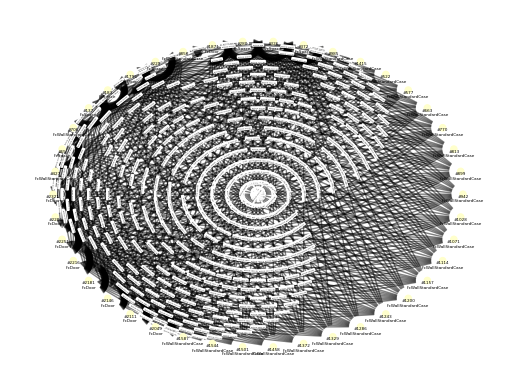

In [49]:
import ifcopenshell
import networkx as nx
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation

def add_to_graph(existing, new, edge_label, G):
    G.add_node(new.id(), **new.get_info())
    G.add_edge(existing.id(), new.id(), weight=7, edge_label=edge_label)

def is_entity_instance(val):
    return val.id() != 0 and isinstance(val, ifcopenshell.entity_instance)

def get_global_coordinates(entity):
    placement = getattr(entity, 'ObjectPlacement', None)
    if placement and placement.is_a('IfcLocalPlacement'):
        relative_placement = placement.RelativePlacement
        if relative_placement and relative_placement.is_a('IfcAxis2Placement3D'):
            location = relative_placement.Location
            if location and hasattr(location, 'Coordinates'):
                return tuple(location.Coordinates)
    return (0.0, 0.0, 0.0)

def calculate_distance(coord1, coord2):
    return math.sqrt(sum((c2 - c1) ** 2 for c1, c2 in zip(coord1, coord2)))

def preprocess_graph_attributes(G):
    for node, data in G.nodes(data=True):
        # Convert non-serializable attributes to strings or remove them
        for key, value in list(data.items()):
            if not isinstance(value, (str, int, float, bool, type(None))):
                data[key] = str(value)

    for u, v, data in G.edges(data=True):
        # Convert non-serializable edge attributes
        for key, value in list(data.items()):
            if not isinstance(value, (str, int, float, bool, type(None))):
                data[key] = str(value)

def create_graph(ifc_file):
    G = nx.DiGraph()
    element_coords = {}

    wall_ids = []
    door_ids = []
    room_ids = []

    for entity in ifc_file:
        info = entity.get_info()

        # Filter walls, doors, and rooms
        if entity.is_a("IfcWallStandardCase") or entity.is_a("IfcWall"):
            wall_ids.append(entity.id())
            G.add_node(entity.id(), **entity.get_info())
            element_coords[entity.id()] = get_global_coordinates(entity)

        elif entity.is_a("IfcDoor"):
            door_ids.append(entity.id())
            G.add_node(entity.id(), **entity.get_info())
            element_coords[entity.id()] = get_global_coordinates(entity)

        elif entity.is_a("IfcSpace"):
            room_ids.append(entity.id())
            room_name = getattr(entity, 'Name', f"Room_{entity.id()}")  # Use the architect-specified name
            G.add_node(entity.id(), **entity.get_info(), label=room_name)  # Add the room name as a label
            element_coords[entity.id()] = get_global_coordinates(entity)

    # Add edges only between walls, doors, and rooms with distance calculation
    for wall in wall_ids:
        for door in door_ids:
            coord1 = element_coords.get(wall, (0.0, 0.0, 0.0))
            coord2 = element_coords.get(door, (0.0, 0.0, 0.0))
            distance = calculate_distance(coord1, coord2)
            G.add_edge(wall, door, edge_label=f"Distance: {distance:.2f}")

        for room in room_ids:
            coord1 = element_coords.get(wall, (0.0, 0.0, 0.0))
            coord2 = element_coords.get(room, (0.0, 0.0, 0.0))
            distance = calculate_distance(coord1, coord2)
            G.add_edge(wall, room, edge_label=f"Distance: {distance:.2f}")

    for door in door_ids:
        for room in room_ids:
            coord1 = element_coords.get(door, (0.0, 0.0, 0.0))
            coord2 = element_coords.get(room, (0.0, 0.0, 0.0))
            distance = calculate_distance(coord1, coord2)
            G.add_edge(door, room, edge_label=f"Distance: {distance:.2f}")

    return G

def draw_graph(G, layout='shell'):
    labels = {}
    for n in G.nodes.values():
        labels[n['id']] = "#" + str(n['id']) + "\n" + n['type']
    cm = []
    for n in G.nodes.values():
        cm.append((1, 1, 0.8))

    edges_labels = {}
    for e in G.edges().data():
        edges_labels[(e[0], e[1])] = e[2]["edge_label"]

    if layout == 'shell':
        pos = nx.shell_layout(G)
    elif layout == 'random':
        pos = nx.random_layout(G)
    else:
        pos = nx.spring_layout(G, k=0.6, iterations=3)

    nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=cm, node_size=20, node_shape='o')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, arrows=True, alpha=0.5)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges_labels, font_size=.01)
    nx.draw_networkx_labels(G, pos, labels=labels, verticalalignment='top', font_size=3)

    plt.axis("off")
    plt.show()

def save_graph_as_gif(G, output_path, frames=50):
    fig, ax = plt.subplots(figsize=(10, 7))

    pos = nx.spring_layout(G, seed=42)

    def update(frame):
        ax.clear()
        updated_pos = {node: (coord[0] + 0.01 * frame, coord[1]) for node, coord in pos.items()}
        nx.draw(G, updated_pos, with_labels=True, ax=ax, node_size=20, font_size=2, edge_color="gray", node_color="blue")
        ax.set_title(f"Frame {frame + 1}/{frames}")

    ani = FuncAnimation(fig, update, frames=frames, interval=200, repeat=False)
    ani.save(output_path, writer="pillow")

if __name__ == "__main__":

    ifc_file_path = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\floorplanexampleroomswithnames.ifc'

    try:
        ifc_file = ifcopenshell.open(ifc_file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error opening IFC file: {e}")

    # Create graph for walls, doors, and rooms
    G = create_graph(ifc_file)

    # Preprocess the graph attributes to ensure compatibility
    preprocess_graph_attributes(G)

    # Print vertices
    print("Vertices:")
    for node_id, data in G.nodes(data=True):
        print(f"Node ID: {node_id}, Data: {data}")

    # Print edges
    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"Edge from {u} to {v}, Data: {data}")

    # Draw the graph
    draw_graph(G, layout='shell')



Vertices:
Node ID: 2321, Data: {'id': 2321, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVlI', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3049=IfcLocalPlacement(#3039,#3048)', 'Representation': '#2317=IfcProductDefinitionShape($,$,(#2316))', 'Tag': '1664109', 'OverallHeight': 2100.0, 'OverallWidth': 850.0}
Node ID: 2286, Data: {'id': 2286, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVkU', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3029=IfcLocalPlacement(#3019,#3028)', 'Representation': '#2282=IfcProductDefinitionShape($,$,(#2281))', 'Tag': '1664033', 'OverallHeight': 2100.0, 'OverallWidth

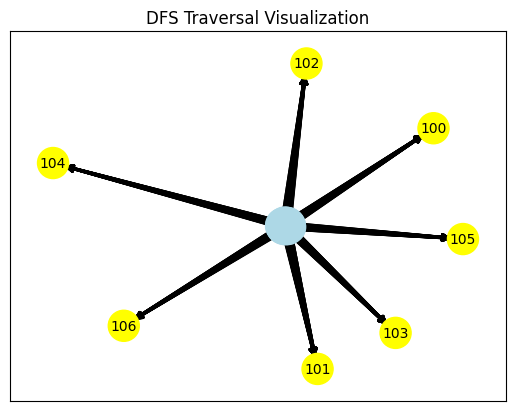

In [53]:
def run_dfs(G, start_node):
    # Perform a DFS traversal from the start node
    visited_nodes = list(nx.dfs_preorder_nodes(G, source=start_node))
    visited_edges = list(nx.dfs_edges(G, source=start_node))

    print(f"DFS Node Visit Order: {visited_nodes}")
    print(f"DFS Edges Traversed: {visited_edges}")

    return visited_nodes, visited_edges


if __name__ == "__main__":
    # File path to the IFC file
    ifc_file_path = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\floorplanexampleroomswithnames.ifc'

    try:
        ifc_file = ifcopenshell.open(ifc_file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error opening IFC file: {e}")

    # Create graph for walls, doors, and rooms
    G = create_graph(ifc_file)

    # Preprocess the graph attributes to ensure compatibility
    preprocess_graph_attributes(G)

    # Print vertices and edges
    print("Vertices:")
    for node_id, data in G.nodes(data=True):
        print(f"Node ID: {node_id}, Data: {data}")

    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"Edge from {u} to {v}, Data: {data}")

    # Specify a start node for DFS
    start_node = list(G.nodes())[0]  # Start from the first node in the graph
    print(f"\nStarting DFS from Node: {start_node}")

    # Run DFS
    visited_nodes, visited_edges = run_dfs(G, start_node)

    # Draw the graph highlighting DFS traversal
    def visualize_dfs(G, visited_nodes, visited_edges):
        pos = nx.spring_layout(G, seed=42)

        # Highlight the nodes and edges in the DFS traversal
        node_colors = ['yellow' if node in visited_nodes else 'lightblue' for node in G.nodes()]
        edge_colors = ['red' if edge in visited_edges else 'black' for edge in G.edges()]

        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
        nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'label'), font_size=10)
        plt.title("DFS Traversal Visualization")
        plt.show()

    visualize_dfs(G, visited_nodes, visited_edges)


In [71]:
import csv
from collections import defaultdict

class UnionFind:
    """
    A simple Union-Find (Disjoint Set) implementation
    """
    def __init__(self):
        self.parent = {}
        self.rank = {}
    
    def find(self, item):
        # Path compression optimization
        if self.parent[item] != item:
            self.parent[item] = self.find(self.parent[item])
        return self.parent[item]
    
    def union(self, a, b):
        rootA = self.find(a)
        rootB = self.find(b)
        
        if rootA != rootB:
            # Union by rank optimization
            if self.rank[rootA] < self.rank[rootB]:
                self.parent[rootA] = rootB
            elif self.rank[rootA] > self.rank[rootB]:
                self.parent[rootB] = rootA
            else:
                self.parent[rootB] = rootA
                self.rank[rootA] += 1
    
    def add(self, item):
        # Add an element if it’s not already present
        if item not in self.parent:
            self.parent[item] = item
            self.rank[item] = 0


def merge_zero_distance_nodes(input_csv, output_csv):
    uf = UnionFind()

    input_csv = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\edges.csv'
    
    edges = []
    
    # 1. Read CSV and populate union-find structure
    with open(input_csv, mode='r', newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        
        for row in reader:
            source = row['Source']
            target = row['Target']
            distance = float(row['Distance'])
            
            # Add nodes to union-find
            uf.add(source)
            uf.add(target)
            
            # Store the edge to rebuild later
            edges.append((source, target, distance))
            
            # If distance=0.0, union these nodes
            if distance == 0.0:
                uf.union(source, target)
    
    # 2. Generate a final mapping from each node to its representative
    representative_map = {}
    for node in uf.parent.keys():    
        rep = uf.find(node)
        representative_map[node] = rep
    
    # 3. Re-map edges to their representatives
    merged_edges = []
    for (source, target, distance) in edges:
        new_source = representative_map[source]
        new_target = representative_map[target]
        
        # If the source and target are the same after merging,
        # it’s effectively a self-loop. Decide if you keep or skip it.
        if new_source != new_target:
            merged_edges.append((new_source, new_target, distance))
    
    # 4. Deduplicate by converting list to a set (if order doesn’t matter).
    #    Otherwise, you might keep it a list and skip duplicates manually.
    merged_edges = list(set(merged_edges))
    
    # 5. Write the output CSV
    with open(output_csv, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(["Source","Target","Distance"])
        for src, tgt, dist in merged_edges:
            writer.writerow([src, tgt, dist])


# Usage
merge_zero_distance_nodes("edges.csv", "edges_merged.csv")


In [54]:
def run_dfs_with_disconnected_nodes(G):
    visited = set()
    traversal = []

    def dfs(node):
        stack = [node]
        while stack:
            current = stack.pop()
            if current not in visited:
                visited.add(current)
                traversal.append(current)
                stack.extend(n for n in G.neighbors(current) if n not in visited)

    # Loop through all nodes to ensure disconnected ones are included
    for node in G.nodes():
        if node not in visited:
            dfs(node)

    return traversal


if __name__ == "__main__":
    # File path to the IFC file
    ifc_file_path = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\floorplanexampleroomswithnames.ifc'

    try:
        ifc_file = ifcopenshell.open(ifc_file_path)
    except Exception as e:
        raise FileNotFoundError(f"Error opening IFC file: {e}")

    # Create graph for walls, doors, and rooms
    G = create_graph(ifc_file)

    # Preprocess the graph attributes to ensure compatibility
    preprocess_graph_attributes(G)

    # Print vertices and edges
    print("Vertices:")
    for node_id, data in G.nodes(data=True):
        print(f"Node ID: {node_id}, Data: {data}")

    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"Edge from {u} to {v}, Data: {data}")

    # Run DFS including disconnected nodes
    dfs_traversal = run_dfs_with_disconnected_nodes(G)
    print("\nDFS Traversal (Including Disconnected Nodes):")
    print(dfs_traversal)


Vertices:
Node ID: 2321, Data: {'id': 2321, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVlI', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3049=IfcLocalPlacement(#3039,#3048)', 'Representation': '#2317=IfcProductDefinitionShape($,$,(#2316))', 'Tag': '1664109', 'OverallHeight': 2100.0, 'OverallWidth': 850.0}
Node ID: 2286, Data: {'id': 2286, 'type': 'IfcDoor', 'GlobalId': '16myiqVj55HBwjlpwIyVkU', 'OwnerHistory': '#18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1734033119)', 'Name': 'Doors : M_Door-Passage-Single-Flush : 750 x 2000mm', 'Description': None, 'ObjectType': 'M_Door-Passage-Single-Flush:750 x 2000mm', 'ObjectPlacement': '#3029=IfcLocalPlacement(#3019,#3028)', 'Representation': '#2282=IfcProductDefinitionShape($,$,(#2281))', 'Tag': '1664033', 'OverallHeight': 2100.0, 'OverallWidth

In [ ]:
import networkx as nx
import pandas as pd

def load_graph_from_csv(nodes_csv, edges_csv):
    # Load nodes and edges from CSV
    nodes_df = pd.read_csv(nodes_csv)
    edges_df = pd.read_csv(edges_csv)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for _, row in nodes_df.iterrows():
        G.add_node(row['Id'], **row.to_dict())
    
    # Add edges with weights
    for _, row in edges_df.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Distance'])
    
    return G

def convert_to_double_side_directed(G):
    # Create a new directed graph for the double-sided graph
    double_sided_G = nx.DiGraph()
    
    # Add nodes
    double_sided_G.add_nodes_from(G.nodes(data=True))
    
    # Add edges in both directions
    for u, v, data in G.edges(data=True):
        double_sided_G.add_edge(u, v, **data)
        double_sided_G.add_edge(v, u, **data)
    
    return double_sided_G

def export_graph_to_csv(G, nodes_csv_path, edges_csv_path):
    # Create nodes dataframe
    nodes_data = [{"Id": n, **G.nodes[n]} for n in G.nodes()]
    nodes_df = pd.DataFrame(nodes_data)

    # Create edges dataframe
    edges_data = [{"Source": u, "Target": v, **data} for u, v, data in G.edges(data=True)]
    edges_df = pd.DataFrame(edges_data)

    # Save to CSV
    nodes_df.to_csv(nodes_csv_path, index=False)
    edges_df.to_csv(edges_csv_path, index=False)

    print(f"Nodes saved to: {nodes_csv_path}")
    print(f"Edges saved to: {edges_csv_path}")

if __name__ == "__main__":
    # Input CSV files
    nodes_csv_path = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\nodes.csv'  # Replace with your actual file path
    edges_csv_path = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\edges_cleaned.csv'  # Replace with your actual file path

    # Output CSV files
    output_nodes_csv = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\changed csvS\double_sided_nodes.csv'  # Replace with your actual file path
    output_edges_csv = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\changed csvS\double_sided_edges.csv'  # Replace with your actual file path

    # Load the graph from CSV files
    G = load_graph_from_csv(nodes_csv_path, edges_csv_path)

    # Convert to double-sided directed graph
    double_sided_G = convert_to_double_side_directed(G)
    
    # Export the double-sided directed graph to new CSV files
    export_graph_to_csv(double_sided_G, output_nodes_csv, output_edges_csv)


Shortest path from 427 to 813: [427, np.float64(2321.0), np.float64(813.0)]
Total distance: 10709.85


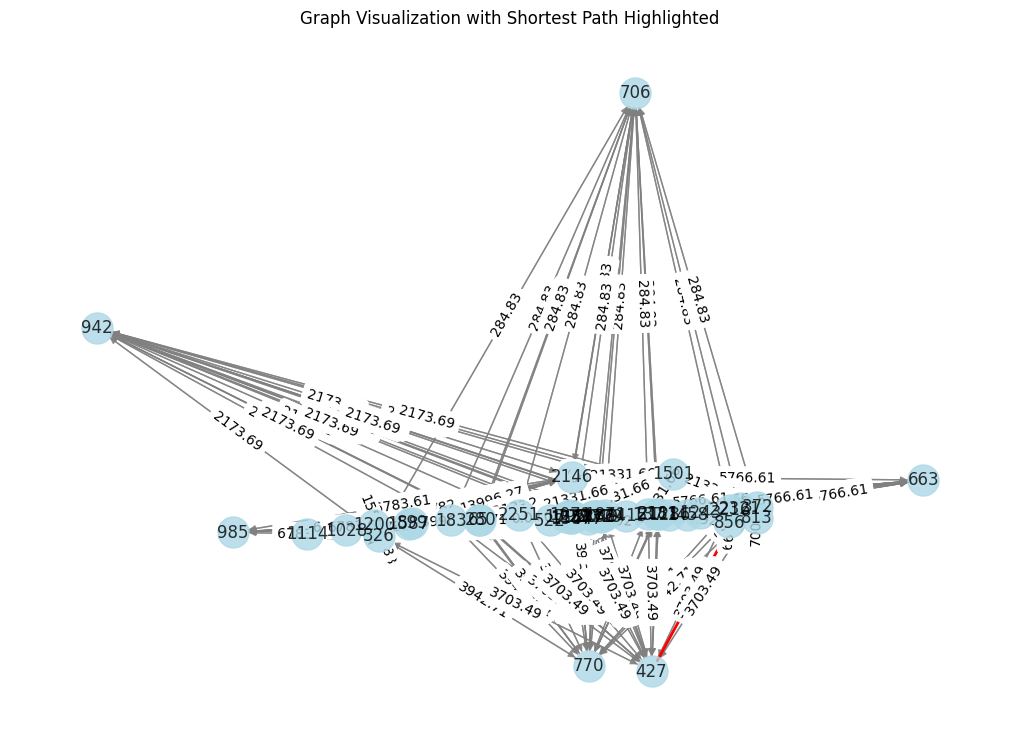

In [14]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

def load_graph_from_csv(nodes_csv, edges_csv):
    # Load nodes and edges from CSV
    nodes_df = pd.read_csv(nodes_csv)
    edges_df = pd.read_csv(edges_csv)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for _, row in nodes_df.iterrows():
        G.add_node(row['Id'], **row.to_dict())
    
    # Add edges with distances as weights
    for _, row in edges_df.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Distance'])
    
    return G

def find_shortest_path(G, source, target):
    try:
        # Find the shortest path using Dijkstra's algorithm
        shortest_path = nx.dijkstra_path(G, source=source, target=target, weight='weight')
        path_length = nx.dijkstra_path_length(G, source=source, target=target, weight='weight')
        
        print(f"Shortest path from {source} to {target}: {shortest_path}")
        print(f"Total distance: {path_length:.2f}")
        return shortest_path, path_length
    except nx.NetworkXNoPath:
        print(f"No path found between {source} and {target}.")
        return None, None

def visualize_graph(G, shortest_path):
    pos = nx.spring_layout(G)  # Position nodes using spring layout
    plt.figure(figsize=(10, 7))
    
    # Draw the full graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, alpha=0.8)
    
    # Highlight the shortest path
    if shortest_path:
        path_edges = list(zip(shortest_path, shortest_path[1:]))
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)
    
    # Draw edge labels for distances
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    plt.title("Graph Visualization with Shortest Path Highlighted")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

if __name__ == "__main__":
    # Input CSV files
    nodes_csv_path = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\changed csvS\double_sided_nodes.csv'  # Replace with your actual file path
    edges_csv_path = r'D:\IaaC\RESEARCH\TRAINING\IFC TO GRPAH\IFC TO GRAPH_METHOD 3_ELEF\REF\changed csvS\double_sided_edges.csv'  # Replace with your actual file path

    # Load the graph from CSV files
    G = load_graph_from_csv(nodes_csv_path, edges_csv_path)

    # Specify source and target nodes
    source_node = int(input("Source node: "))
    target_node = int(input("Target node: "))
    
    # Find the shortest path
    shortest_path, path_length = find_shortest_path(G, source_node, target_node)
    
    # Visualize the graph and the shortest path
    visualize_graph(G, shortest_path)


In [ ]:
import networkx as nx
import pandas as pd

def load_graph_from_csv(nodes_csv, edges_csv):
    # Load nodes and edges from CSV
    nodes_df = pd.read_csv(nodes_csv)
    edges_df = pd.read_csv(edges_csv)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add nodes
    for _, row in nodes_df.iterrows():
        G.add_node(row['Id'], **row.to_dict())
    
    # Add edges with distances as weights
    for _, row in edges_df.iterrows():
        G.add_edge(row['Source'], row['Target'], weight=row['Distance'])
    
    return G, nodes_df, edges_df

def calculate_weights(G, nodes_df, edges_df):
    # Calculate weights for each node based on the given equation
    for node in G.nodes():
        importance = nodes_df.loc[nodes_df['Id'] == node, 'Importance'].values[0]
        connectivity = G.degree(node)  # Connectivity is the degree of the node
        distance = edges_df.loc[(edges_df['Source'] == node) | (edges_df['Target'] == node), 'Distance'].mean()
        crowdedness = nodes_df.loc[nodes_df['Id'] == node, 'Crowdedness'].values[0]
        width = nodes_df.loc[nodes_df['Id'] == node, 'Width'].values[0]
        
        weight = (importance * connectivity) / (distance * crowdedness * width)
        G.nodes[node]['weight'] = weight

def convert_to_double_side_directed(G):
    # Create a new directed graph for the double-sided graph
    double_sided_G = nx.DiGraph()
    
    # Add nodes
    double_sided_G.add_nodes_from(G.nodes(data=True))
    
    # Add edges in both directions
    for u, v, data in G.edges(data=True):
        double_sided_G.add_edge(u, v, **data)
        double_sided_G.add_edge(v, u, **data)
    
    return double_sided_G

def export_graph_to_csv(G, nodes_csv_path, edges_csv_path):
    # Create nodes dataframe
    nodes_data = [{"Id": n, **G.nodes[n]} for n in G.nodes()]
    nodes_df = pd.DataFrame(nodes_data)

    # Create edges dataframe
    edges_data = [{"Source": u, "Target": v, **data} for u, v, data in G.edges(data=True)]
    edges_df = pd.DataFrame(edges_data)

    # Save to CSV
    nodes_df.to_csv(nodes_csv_path, index=False)
    edges_df.to_csv(edges_csv_path, index=False)

    print(f"Nodes saved to: {nodes_csv_path}")
    print(f"Edges saved to: {edges_csv_path}")

if __name__ == "__main__":
    # Input CSV files
    nodes_csv_path = r'path\to\your\nodes.csv'  # Replace with your actual file path
    edges_csv_path = r'path\to\your\edges.csv'  # Replace with your actual file path

    # Output CSV files
    output_nodes_csv = r'path\to\your\double_sided_nodes.csv'  # Replace with your actual file path
    output_edges_csv = r'path\to\your\double_sided_edges.csv'  # Replace with your actual file path

    # Load the graph from CSV files
    G, nodes_df, edges_df = load_graph_from_csv(nodes_csv_path, edges_csv_path)

    # Calculate weights for nodes
    calculate_weights(G, nodes_df, edges_df)

    # Convert to double-sided directed graph
    double_sided_G = convert_to_double_side_directed(G)
    
    # Export the double-sided directed graph to new CSV files
    export_graph_to_csv(double_sided_G, output_nodes_csv, output_edges_csv)
